<a href="https://colab.research.google.com/github/c0mrade120/firewall-ml/blob/main/notebooks/firewall_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ============================================
# Практическое задание №2
# Реализация моделей классического машинного обучения
# Анализ сетевого трафика (CIC IDS 2017)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('/content/firewall_data/log2.csv')
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [34]:
# БЛОК 2 — ЗАГРУЗКА ТВОЕГО ДАТАСЕТА (ищем CSV в 'firewall_data')
import os
import pandas as pd

base_dir = "/content"
search_dirs = ["firewall_data", "."]  # ищем сначала в firewall_data, потом в корне
csv_path = None

for d in search_dirs:
    full = os.path.join(base_dir, d)
    if os.path.isdir(full):
        for fname in sorted(os.listdir(full)):
            if fname.lower().endswith(".csv"):
                csv_path = os.path.join(full, fname)
                break
    if csv_path:
        break

# если не нашли, попробуем посмотреть корень
if csv_path is None:
    for fname in sorted(os.listdir(base_dir)):
        if fname.lower().endswith(".csv"):
            csv_path = os.path.join(base_dir, fname)
            break

if csv_path is None:
    raise FileNotFoundError("CSV файл не найден — положи файл в /content или /content/firewall_data")

print("Загружаем файл:", csv_path)
df = pd.read_csv(csv_path)
print("Размер:", df.shape)
display(df.head())

Загружаем файл: /content/firewall_data/log2.csv
Размер: (65532, 12)


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [35]:
# БЛОК 3 — ОСНОВНАЯ ИНФОРМАЦИЯ
print("Столбцы:", list(df.columns))
print("\nКоличество строк, столбцов:", df.shape)
print("\nУникальные значения в 'Action':", df['Action'].value_counts().to_dict())

display(df.info())
display(df.describe(include='all').T)

Столбцы: ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

Количество строк, столбцов: (65532, 12)

Уникальные значения в 'Action': {'allow': 37640, 'deny': 14987, 'drop': 12851, 'reset-both': 54}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Source Port,65532.0,NaN,NaN,NaN,49391.969343,15255.712537,0.0,49183.0,53776.5,58638.0,65534.0
Destination Port,65532.0,NaN,NaN,NaN,10577.385812,18466.027039,0.0,80.0,445.0,15000.0,65535.0
NAT Source Port,65532.0,NaN,NaN,NaN,19282.972761,21970.689669,0.0,0.0,8820.5,38366.25,65535.0
NAT Destination Port,65532.0,NaN,NaN,NaN,2671.04993,9739.162278,0.0,0.0,53.0,443.0,65535.0
Action,65532,4,allow,37640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bytes,65532.0,NaN,NaN,NaN,97123.950085,5618438.909052,60.0,66.0,168.0,752.25,1269359015.0
Bytes Sent,65532.0,NaN,NaN,NaN,22385.796908,3828138.649785,60.0,66.0,90.0,210.0,948477220.0
Bytes Received,65532.0,NaN,NaN,NaN,74738.153177,2463207.711884,0.0,0.0,79.0,449.0,320881795.0
Packets,65532.0,NaN,NaN,NaN,102.866035,5133.002346,1.0,1.0,2.0,6.0,1036116.0
Elapsed Time (sec),65532.0,NaN,NaN,NaN,65.833577,302.461762,0.0,0.0,15.0,30.0,10824.0


In [36]:
# БЛОК 4 — ПРЕДОБРАБОТКА
import numpy as np

df_proc = df.copy()

# Нормализуем названия столбцов на случай лишних пробелов
df_proc.columns = [c.strip() for c in df_proc.columns]

# 1) Создаём целевую бинарную метку: 0 = allow (нормально), 1 = всё остальное (атакуем/нештат)
df_proc['Label'] = df_proc['Action'].apply(lambda x: 0 if str(x).strip().lower() == 'allow' else 1).astype(int)

# 2) Выделяем числовые столбцы (попытаемся конвертировать строковые числовые в числа)
num_cols = []
for c in df_proc.columns:
    if c == 'Action' or c == 'Label':
        continue
    # попытка привести к числу
    coerced = pd.to_numeric(df_proc[c], errors='coerce')
    if coerced.notna().sum() > 0:  # если есть хоть какие-то числа
        df_proc[c] = coerced
    # считаем тип
    if pd.api.types.is_numeric_dtype(df_proc[c]):
        num_cols.append(c)

print("Числовые колонки:", num_cols)

# 3) Создадим датафрейм только с числовыми признаками (для моделей и визуализации)
df_numeric = df_proc[num_cols].copy()

# 4) Заполняем пропуски средними по столбцу (только в числовом DF)
df_numeric = df_numeric.fillna(df_numeric.mean())

print("Размер числового DF:", df_numeric.shape)
display(df_numeric.head())


Числовые колонки: ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
Размер числового DF: (65532, 11)


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,177,94,83,2,30,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,13,18


Колонки для гистограмм: ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']


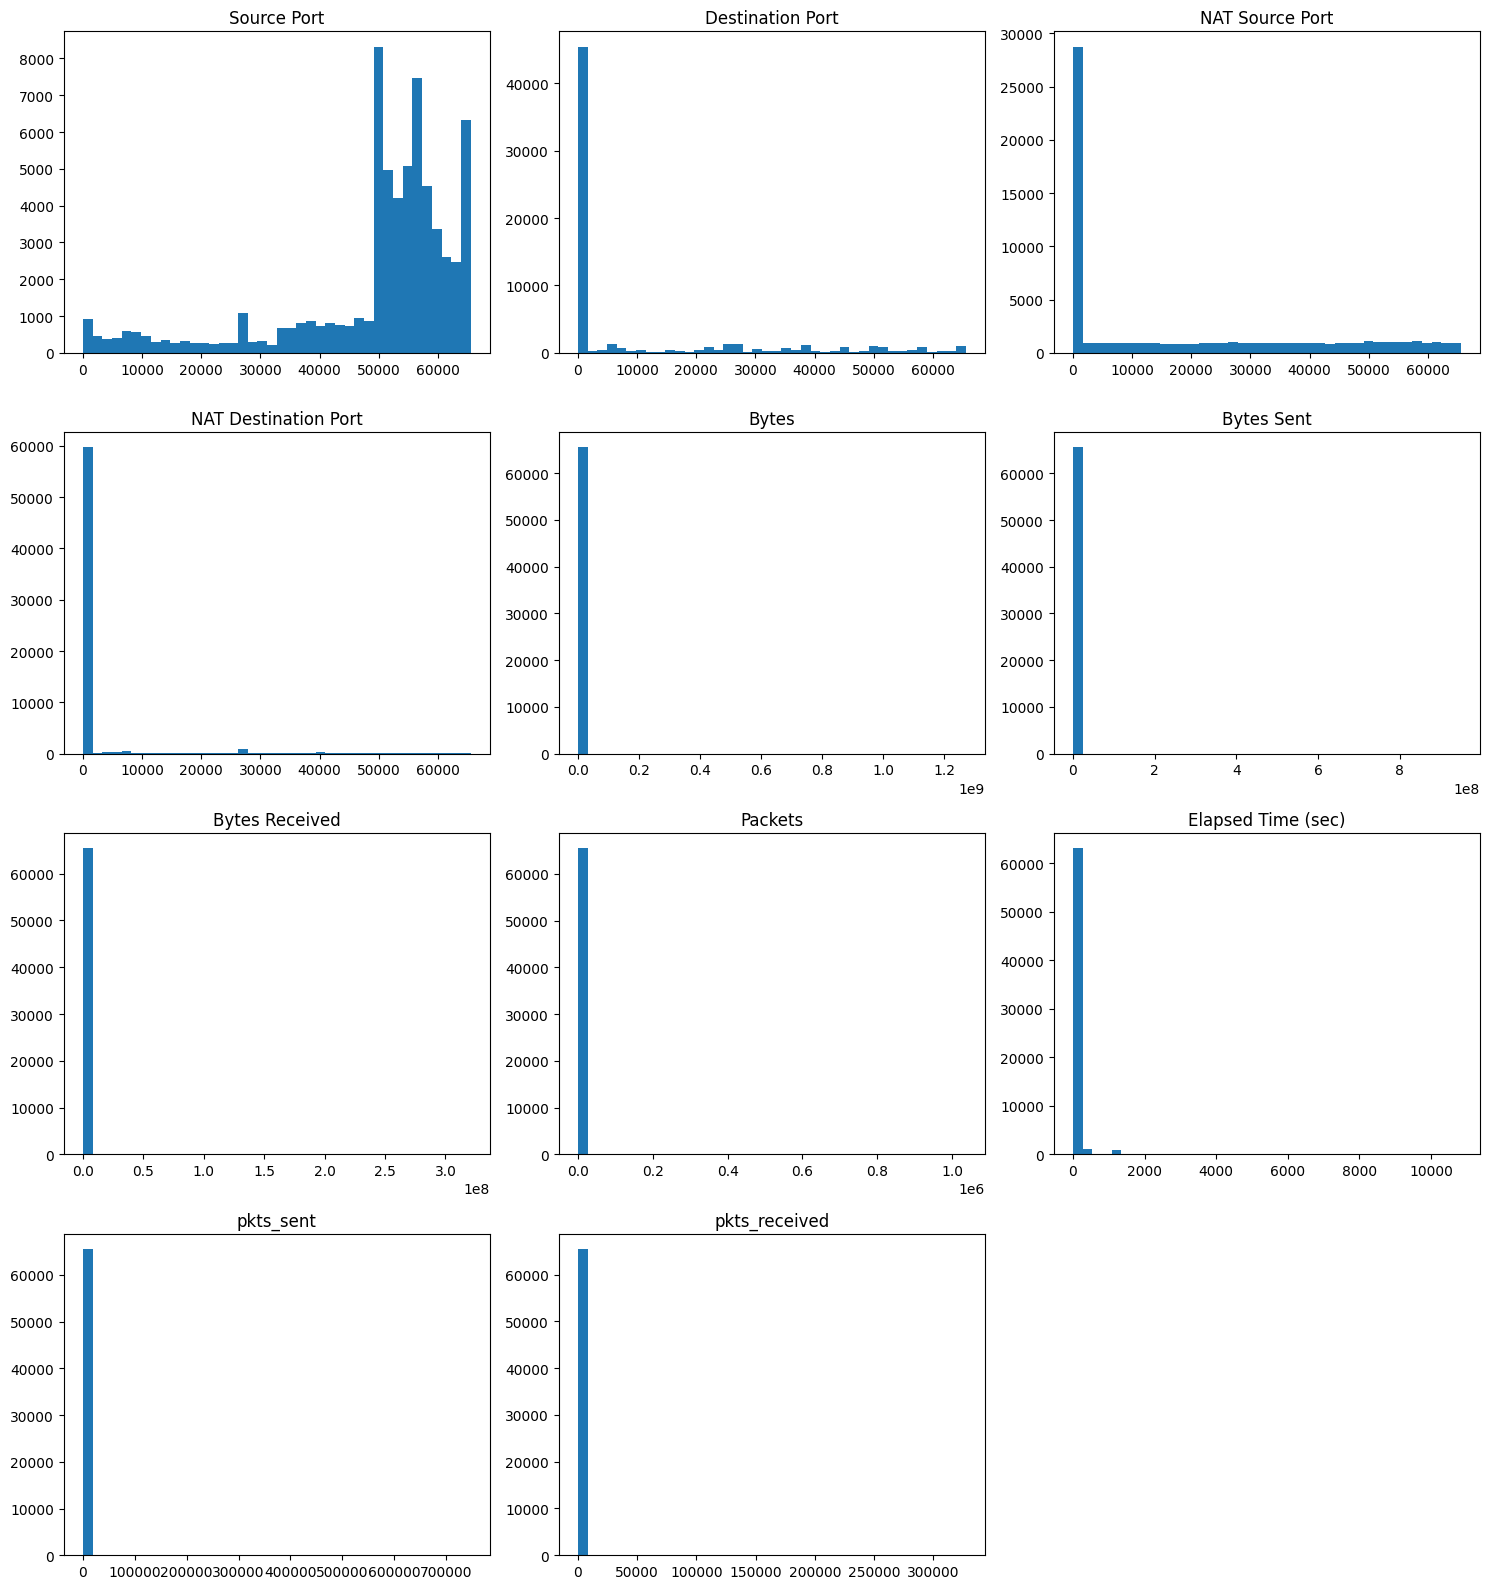

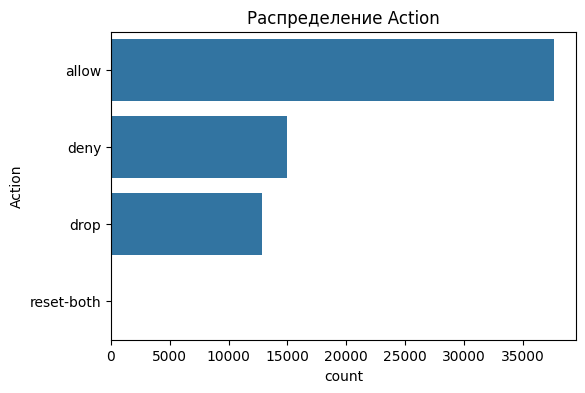

In [37]:
# БЛОК 5 — ГИСТОГРАММЫ ТОЛЬКО ДЛЯ ЧИСЛОВЫХ СЕНСОРНЫХ КОЛОНОК (у которых >1 уникального значения)
import matplotlib.pyplot as plt
import math

numeric_for_plot = [c for c in df_numeric.columns if df_numeric[c].nunique() > 1]
print("Колонки для гистограмм:", numeric_for_plot)

n = len(numeric_for_plot)
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(numeric_for_plot):
    plt.subplot(rows, cols, i+1)
    plt.hist(df_numeric[col].dropna(), bins=40)
    plt.title(col)
    # для сильно скошенных признаков можно включить лог-шкалу:
    # plt.yscale('log')

plt.tight_layout()
plt.show()

# Категориальная диаграмма для Action
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(y=df_proc['Action'], order=df_proc['Action'].value_counts().index)
plt.title('Распределение Action')
plt.show()

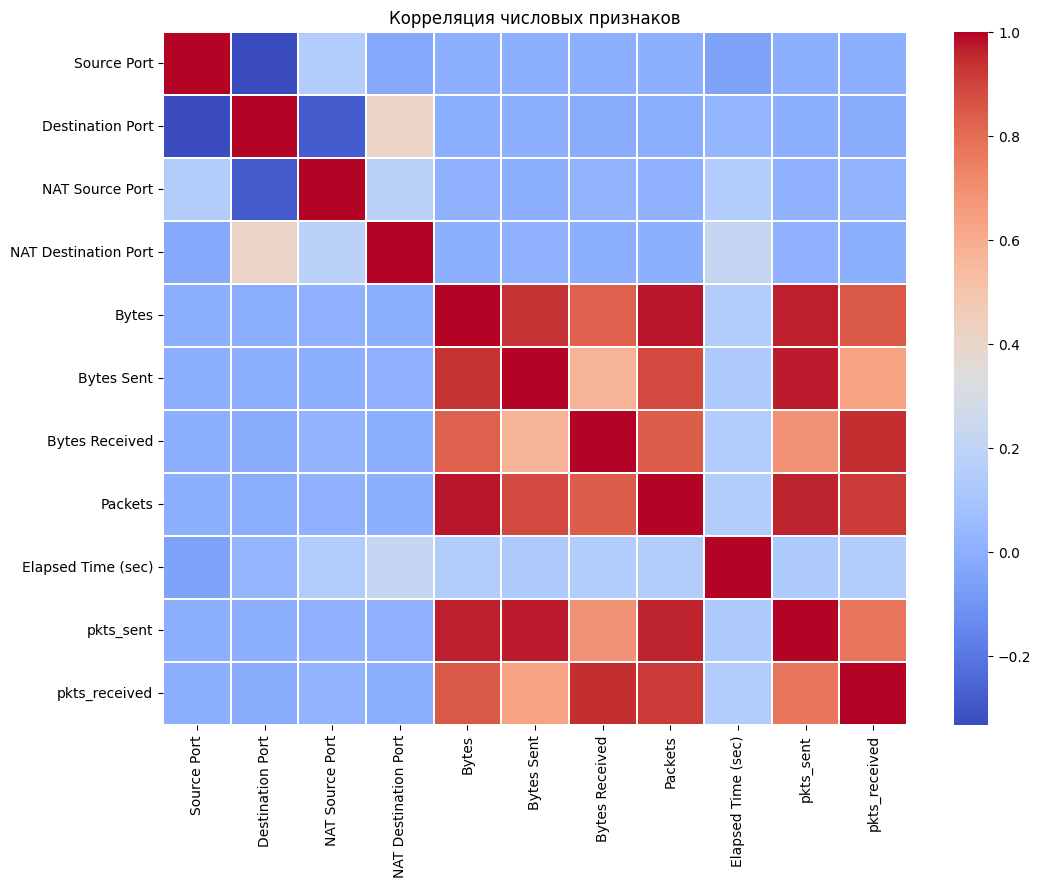

In [38]:
# БЛОК 6 — МАТРИЦА КОРРЕЛЯЦИЙ
plt.figure(figsize=(12,9))
corr = df_numeric.corr()
sns.heatmap(corr, cmap="coolwarm", linewidths=0.2)
plt.title("Корреляция числовых признаков")
plt.show()


In [39]:
f# БЛОК 7 — ПОДГОТОВКА ДЛЯ ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X — числовые признаки, y — Label (0/1)
X = df_numeric.copy()
y = df_proc['Label'].astype(int).values

# небольшая защита: удалим колонки с нулевой дисперсией
const_cols = X.columns[X.std() == 0].tolist()
if const_cols:
    print("Удаляем константные колонки:", const_cols)
    X = X.drop(columns=const_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels distribution:", pd.Series(y_train).value_counts(normalize=True).to_dict())


Train shape: (52425, 11) Test shape: (13107, 11)
Train labels distribution: {0: 0.5743824511206486, 1: 0.42561754887935144}


Accuracy: 0.9996948195620661
Precision: 0.9994624619243863
Recall: 0.9998207564079584
F1: 0.9996415770609319

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7528
           1       1.00      1.00      1.00      5579

    accuracy                           1.00     13107
   macro avg       1.00      1.00      1.00     13107
weighted avg       1.00      1.00      1.00     13107



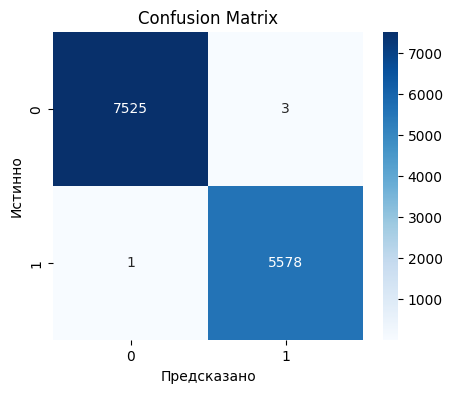

,feature,importance
8,Elapsed Time (sec),0.310169
2,NAT Source Port,0.248049
3,NAT Destination Port,0.184373
7,Packets,0.089733
10,pkts_received,0.077081
6,Bytes Received,0.054484
4,Bytes,0.020850
5,Bytes Sent,0.008253
9,pkts_sent,0.004605
1,Destination Port,0.001874


In [40]:
# БЛОК 8 — RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Confusion Matrix")
plt.show()

# Важность признаков
feat_names = X.columns
importances = clf.feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
display(imp_df.head(15))


R2: 0.9138031149030138
MAE: 9626.75171689428


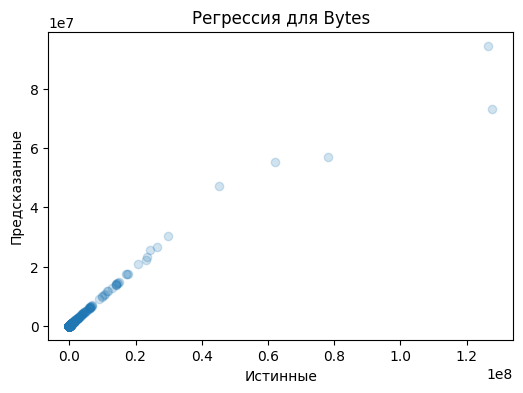

In [41]:
# БЛОК 9 — РЕГРЕССИЯ (RandomForestRegressor) на таргете Bytes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# проверим, есть ли колонка Bytes
if 'Bytes' in df_numeric.columns:
    target = 'Bytes'
else:
    # если нет — берем первый числовой столбец
    target = df_numeric.columns[0]
    print("Bytes не найдена, используем в качестве таргета:", target)

X_reg = df_numeric.drop(columns=[target])
y_reg = df_numeric[target].fillna(0)

# Конвертируем в массивы
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg.values, y_reg.values, test_size=0.2, random_state=42
)

reg_scaler = StandardScaler()
Xr_train = reg_scaler.fit_transform(Xr_train)
Xr_test = reg_scaler.transform(Xr_test)

reg = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
reg.fit(Xr_train, yr_train)

pred_reg = reg.predict(Xr_test)

print("R2:", r2_score(yr_test, pred_reg))
print("MAE:", mean_absolute_error(yr_test, pred_reg))

plt.figure(figsize=(6,4))
plt.scatter(yr_test, pred_reg, alpha=0.2)
plt.xlabel("Истинные")
plt.ylabel("Предсказанные")
plt.title(f"Регрессия для {target}")
plt.show()

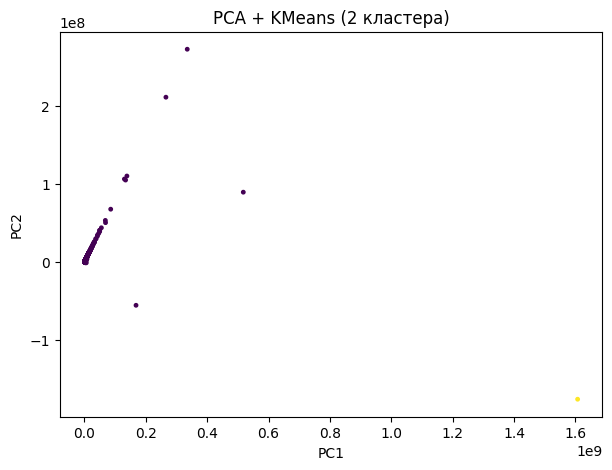

Silhouette score: 0.9998487000809487


Label,0,1
cluster,,
0,37639,27892
1,1,0


In [42]:
# БЛОК 10 — PCA + KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# используем df_numeric (без таргета)
X_cluster = df_numeric.copy()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

# пробуем 2 кластера (нормально/аномалия) — можно искать оптимальное k
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, s=6, cmap='viridis')
plt.title("PCA + KMeans (2 кластера)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Silhouette score:", silhouette_score(X_pca, clusters))

# Сравним кластеры с меткой Label
cluster_vs_label = pd.crosstab(pd.Series(clusters, name='cluster'), df_proc['Label'].iloc[X_cluster.index])
display(cluster_vs_label)


In [43]:
# БЛОК 11 — СОХРАНЕНИЕ МОДЕЛИ И ВЫВОДЫ
import joblib
joblib.dump(clf, "/content/random_forest_firewall_clf.joblib")
joblib.dump(reg, "/content/random_forest_firewall_reg.joblib")
print("Модели сохранены: /content/random_forest_firewall_clf.joblib и ..._reg.joblib")

Модели сохранены: /content/random_forest_firewall_clf.joblib и ..._reg.joblib
